In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import IPython.display as ipd
import imageio
import copy
from tensorboardX import SummaryWriter
import pickle 

writeTensorboard = False
if(writeTensorboard):
    writer = SummaryWriter('tensorboard/run1/')

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
sns.set(color_codes=True)
sns.set_style("whitegrid")

model_dir = "./models/"
import models
from plot_utils import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot
from model_utils import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty
from helpers import trueAfterN, logsumexp
from sws_utils import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune


#Data
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False , transform=transforms.ToTensor(), download=True)

batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
train_data_full = Variable(train_dataset.train_data.float()/255.0).cuda()
test_data_full = Variable(test_dataset.test_data.float()/255.0).cuda()
train_labels_full = Variable(train_dataset.train_labels).cuda()
test_labels_full = Variable(test_dataset.test_labels).cuda()

#arguments
#model_name = 'LeNet_300_100'
training_epochs=100
#retraining_epochs=50
#temp_list = [1, 5, 10, 15, 20, 25, 30]

In [3]:
#4D tensor fix for conv-net
test_data_full = test_data_full.view(10000, 1, 28, 28)
train_data_full = train_data_full.view(60000, 1, 28, 28)
model_name = 'SWSModel'

### 1. Train Model

**Default Training**

Epoch: 10. Training Accuracy: 99.23. Test Accuracy: 98.65
Epoch: 20. Training Accuracy: 99.54. Test Accuracy: 98.88
Epoch: 30. Training Accuracy: 99.58. Test Accuracy: 98.71
Epoch: 40. Training Accuracy: 99.72. Test Accuracy: 98.98
Epoch: 50. Training Accuracy: 99.76. Test Accuracy: 98.99
Epoch: 60. Training Accuracy: 99.69. Test Accuracy: 98.77
Epoch: 70. Training Accuracy: 99.82. Test Accuracy: 99.04
Epoch: 80. Training Accuracy: 99.79. Test Accuracy: 98.9
Epoch: 90. Training Accuracy: 99.77. Test Accuracy: 99.08
Epoch: 100. Training Accuracy: 99.74. Test Accuracy: 98.91


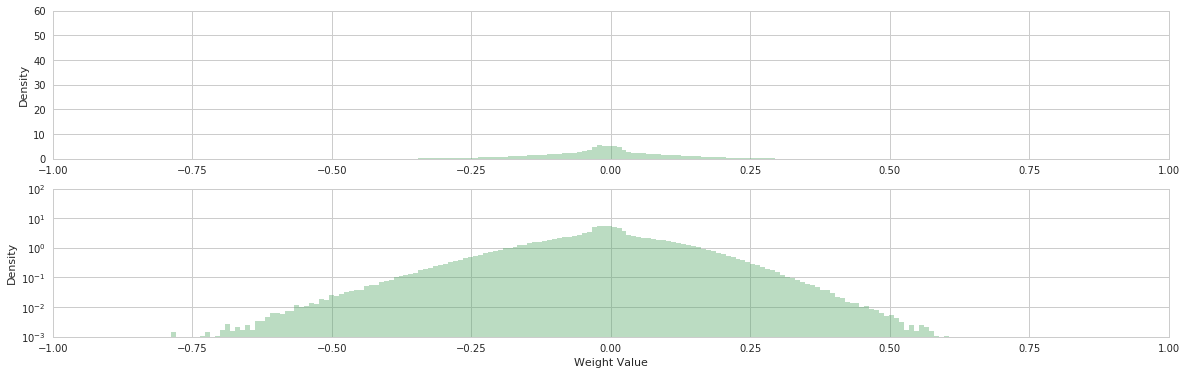

In [6]:
model = models.SWSModel().cuda()
#print_dims(model)
ipd.display(ipd.Markdown("**Default Training**"))

criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.000)
graph_title='sws_original_model/'

for epoch in range(training_epochs):
    model, loss = train_epoch(model, optimizer, criterion, train_loader)
    
    test_acc = test_accuracy(test_data_full, test_labels_full, model)
    train_acc = test_accuracy(train_data_full, train_labels_full, model)
    weight_penalty = get_weight_penalty(model)
    
    if(writeTensorboard):
        writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Test': test_acc[1], 'Train': train_acc[1]}, epoch+1)
        writer.add_scalars(graph_title + 'Accuracy', {'Test': test_acc[0], 'Train': train_acc[0]}, epoch+1)
        writer.add_scalars(graph_title + 'L2', {'L2' : weight_penalty}, epoch+1)
        for name, param in model.named_parameters():
            writer.add_histogram(graph_title + name, param.clone().cpu().data.numpy(), epoch+1, bins='doane')
    if (trueAfterN(epoch, 10)):
        print('Epoch: {}. Training Accuracy: {:.2f}. Test Accuracy: {}'.format(epoch+1, train_acc[0], test_acc[0]))
    
show_sws_weights(model)
torch.save(model, model_dir + 'mnist_{}_{}.m'.format(model.name, training_epochs))

### 2. Re-train Model with GMM Constraints

In [10]:
%%notify

alpha, beta = (25000, 10)
model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, training_epochs)).cuda()
model_retrain = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, training_epochs)).cuda()
gmp = GaussianMixturePrior(16, [x for x in model_retrain.parameters()], 0.99, ab = (alpha, beta))

test_acc = test_accuracy(test_data_full, test_labels_full, model_retrain)
train_acc = test_accuracy(train_data_full, train_labels_full, model_retrain)
acc_history = np.array([train_acc[0], test_acc[0]])
stddev_history = np.sqrt(1. / gmp.gammas.exp().data.clone().cpu().numpy())
mean_history = gmp.means.data.clone().cpu().numpy()
mixprop_history = gmp.rhos.exp().data.clone().cpu().numpy()

sws_param1 = [gmp.means]
sws_param2 = [gmp.gammas, gmp.rhos]
#ipd.display(ipd.Markdown("**Default Training**"))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_retrain.parameters(), lr=1e-4)
optimizer_gmp1 = torch.optim.Adam(sws_param1, lr=1e-4)
optimizer_gmp2 = torch.optim.Adam(sws_param2, lr=3e-3)
graph_title='retrain_model/'

retraining_epochs = 40
decay = np.linspace(5e-7, 5e-6, retraining_epochs)
#decay = 5e-7 * np.power(10, decay)
#decay = 5e-5 * (1 - 1 / np.power(10, decay))

exp_name = "m{}_a{}_b{}_r{}".format(model_retrain.name, alpha, beta, retraining_epochs)

for epoch in range(retraining_epochs):
    ipd.display(ipd.Markdown("**Epoch: {}**".format(epoch+1)))
    #tau = float(decay[epoch])
    tau=5e-7
    model_retrain, loss = retrain_sws_epoch(model_retrain, gmp, optimizer, optimizer_gmp1, optimizer_gmp2, criterion, train_loader, tau)

    test_acc = test_accuracy(test_data_full, test_labels_full, model_retrain)
    train_acc = test_accuracy(train_data_full, train_labels_full, model_retrain)
    weight_penalty = get_weight_penalty(model_retrain)

    stddev_history = np.vstack((stddev_history,  np.sqrt(1. / gmp.gammas.exp().data.clone().cpu().numpy()) ))
    mean_history = np.vstack((mean_history, gmp.means.data.clone().cpu().numpy() ))
    mixprop_history = np.vstack((mixprop_history, gmp.rhos.exp().data.clone().cpu().numpy() ))
    acc_history = np.vstack(( acc_history, np.array([train_acc[0], test_acc[0]]) ))

    if(writeTensorboard):
        writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Test': test_acc[1], 'Train': train_acc[1]}, epoch+1)
        writer.add_scalars(graph_title + 'Accuracy', {'Test': test_acc[0], 'Train': train_acc[0]}, epoch+1)
        writer.add_scalars(graph_title + 'L2', {'L2' : weight_penalty}, epoch+1)
        for name, param in model_retrain.named_parameters():
            writer.add_histogram(graph_title + name, param.clone().cpu().data.numpy(), epoch+1, bins='doane')
    if (trueAfterN(epoch, 10)):
        gmp.print_batch = True
        print ('Tau:{}'.format(tau))
        print('Epoch: {}. Training Accuracy: {:.2f}. Test Accuracy: {}'.format(epoch+1, train_acc[0], test_acc[0]))
        print ( "Means: {}".format(list(np.around(gmp.means.data.clone().cpu().numpy(),3))) )
        print ( "Mixing Proportions: {}".format(list(np.around(gmp.rhos.data.clone().cpu().numpy(),3))) )
        print ( "Precisions: {}".format(list(np.around(gmp.gammas.data.clone().cpu().numpy(),3))) )
    show_sws_weights(model = model_retrain, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()), epoch = epoch, accuracy = test_acc[0], savefile = exp_name)
    joint_plot(model_retrain, model, gmp, epoch, retraining_epochs, test_acc[0], savefile = exp_name)
        #show_all_weights(model_retrain)

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'models.SWSModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 2500.0 Variance: 250.0


**Epoch: 1**

Layer Loss: 615.152
Layer Loss: 14.212
Layer Loss: 8181.761
Layer Loss: 26.018
Layer Loss: 367156.969
Layer Loss: 247.160
Layer Loss: 3322.494
Layer Loss: 5.680
0-neglogprop Loss: -13828.171
Remaining-neglogprop Loss: -1037279.125


**Epoch: 2**

**Epoch: 3**

**Epoch: 4**

**Epoch: 5**

**Epoch: 6**

**Epoch: 7**

**Epoch: 8**

**Epoch: 9**

**Epoch: 10**

Tau:5e-07
Epoch: 10. Training Accuracy: 99.84. Test Accuracy: 99.01
Means: [-0.454, -0.687, -0.45, -0.209, -0.225, -0.152, -0.028, -0.004, 0.026, 0.185, 0.211, 0.213, 0.54, 0.425, 0.296]
Mixing Proportions: [-0.482, -3.1, -7.329, -4.387, 0.011, -6.032, -5.622, -5.586, -5.784, -6.544, -6.143, -6.667, -5.024, -3.265, -0.725]
Precisions: [6.733, 7.769, 7.789, 7.794, 7.794, 7.754, 7.794, 7.794, 7.794, 7.794, 7.794, 7.794, 7.794, 7.794, 7.791, 7.71]


**Epoch: 11**

Layer Loss: 4738.039
Layer Loss: 51.956
Layer Loss: 28440.377
Layer Loss: 39.283
Layer Loss: -670536.438
Layer Loss: -711.069
Layer Loss: 10406.347
Layer Loss: 12.418
0-neglogprop Loss: -31978.908
Remaining-neglogprop Loss: -2558507.500


**Epoch: 12**

**Epoch: 13**

**Epoch: 14**

**Epoch: 15**

**Epoch: 16**

**Epoch: 17**

**Epoch: 18**

**Epoch: 19**

**Epoch: 20**

Tau:5e-07
Epoch: 20. Training Accuracy: 99.42. Test Accuracy: 98.53
Means: [-0.452, -0.683, -0.45, -0.207, -0.215, -0.075, -0.135, -0.082, 0.036, 0.193, 0.155, 0.188, 0.486, 0.318, 0.135]
Mixing Proportions: [-1.478, -4.63, -10.924, -8.134, -0.72, -1.592, -5.408, -9.096, -9.374, -10.169, -10.746, -11.018, -4.912, -2.129, -0.058]
Precisions: [11.97, 7.838, 7.824, 7.824, 7.824, 7.823, 7.824, 7.824, 7.824, 7.824, 7.824, 7.824, 7.824, 7.822, 7.811, 7.548]


**Epoch: 21**

Layer Loss: 5457.409
Layer Loss: 159.654
Layer Loss: -3086.758
Layer Loss: -14.223
Layer Loss: -2468182.500
Layer Loss: -2066.646
Layer Loss: 9757.337
Layer Loss: -9.724
0-neglogprop Loss: 256073.609
Remaining-neglogprop Loss: -2558025.000


**Epoch: 22**

**Epoch: 23**

**Epoch: 24**

**Epoch: 25**

**Epoch: 26**

**Epoch: 27**

**Epoch: 28**

**Epoch: 29**

**Epoch: 30**

Tau:5e-07
Epoch: 30. Training Accuracy: 99.59. Test Accuracy: 98.64
Means: [-0.453, -0.679, -0.45, -0.207, -0.217, -0.077, -0.133, -0.082, 0.026, 0.193, 0.155, 0.188, 0.498, 0.32, 0.136]
Mixing Proportions: [-1.035, -4.167, -12.041, -9.269, -0.276, -1.147, -6.786, -10.251, -10.508, -11.299, -11.875, -12.145, -4.477, -1.683, 0.381]
Precisions: [11.972, 7.842, 7.825, 7.824, 7.824, 7.842, 7.826, 7.824, 7.824, 7.824, 7.824, 7.824, 7.824, 7.823, 7.816, 7.672]


**Epoch: 31**

Layer Loss: 5215.522
Layer Loss: 154.906
Layer Loss: -4073.276
Layer Loss: -19.093
Layer Loss: -2471467.250
Layer Loss: -2067.612
Layer Loss: 8957.420
Layer Loss: -10.811
0-neglogprop Loss: 256693.656
Remaining-neglogprop Loss: -2558615.000


**Epoch: 32**

**Epoch: 33**

**Epoch: 34**

**Epoch: 35**

**Epoch: 36**

**Epoch: 37**

**Epoch: 38**

**Epoch: 39**

**Epoch: 40**

Tau:5e-07
Epoch: 40. Training Accuracy: 99.64. Test Accuracy: 98.66
Means: [-0.454, -0.679, -0.45, -0.207, -0.219, -0.08, -0.133, -0.082, 0.028, 0.194, 0.155, 0.188, 0.511, 0.323, 0.137]
Mixing Proportions: [-0.705, -3.835, -12.907, -10.182, 0.053, -0.817, -7.761, -11.163, -11.416, -12.191, -12.751, -13.022, -4.158, -1.351, 0.71]
Precisions: [11.973, 7.844, 7.825, 7.824, 7.824, 7.85, 7.825, 7.824, 7.824, 7.824, 7.824, 7.824, 7.824, 7.823, 7.819, 7.737]


<IPython.core.display.Javascript object>

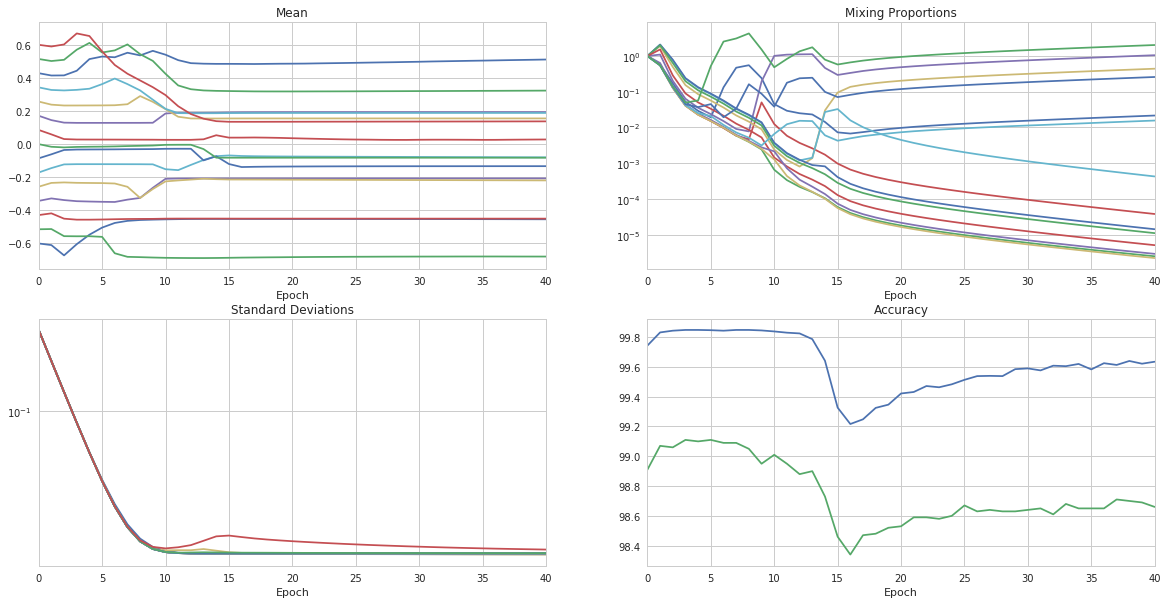

In [11]:
draw_sws_graphs(mean_history, stddev_history, mixprop_history, acc_history, exp_name)
images = []
filenames = ["figs/{}_{}.png".format(exp_name, x) for x in range(1,retraining_epochs+1)]
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./exp/{}.gif'.format(exp_name), images)
torch.save(model_retrain, model_dir + 'mnist_retrain_{}.m'.format(exp_name))
with open(model_dir + 'mnist_retrain_{}.m'.format(exp_name),'wb') as f:
    pickle.dump(gmp, f)
ipd.HTML('<img src="./exp/{}.gif">'.format(exp_name))

In [12]:
images = []
filenames = ["figs/jp_{}_{}.png".format(exp_name, x) for x in range(1,retraining_epochs+2)]
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./exp/jp_{}.gif'.format(exp_name), images)
ipd.HTML('<img src="./exp/jp_{}.gif">'.format(exp_name))

### 3. Prune Model

In [14]:
model_prune = torch.load(model_dir + 'mnist_retrain_{}.m'.format(exp_name)).cuda()
model_prune.load_state_dict(sws_prune(model_prune, gmp))
test_accuracy(test_data_full, test_labels_full, pruned_model)
show_sws_weights(model_prune)

RuntimeError: Invalid magic number; corrupt file?

In [ ]:
1/(1-(special_flatten(pruned_model.state_dict())==0).sum()/642460.0)